---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

In this section, the goal is to build machine learning models to investigate the drivers of our target variables: chronic absenteeism, dropout risk, and college persistence. We will create three different models: a regression, a binary classification, and a multivariate classification. For each, we will test various algorithms and identify the one that performs best.

I developed several functions to streamline the modeling process. These functions handle preprocessing, training, tuning, scoring the validation set, and scoring the test set.

1. *Preprocessing*: This function takes a dataframe, target column, and test size as inputs. It splits the data into training, validation, and test sets. The training set is used to train the models, the validation set is crucial for tuning hyperparameters, and the test set evaluates the model's performance on unseen data.

2. *Train*: This function accepts X_train, y_train, learning_task_type, model_type, and **kwargs. The learning_task_type should be either 'classification' or 'regression', while model_type specifies the algorithm to be used. The **kwargs parameter allows additional arguments to be passed to the algorithm, which is used once the model is tuned.

3. *Tune*: This function takes a model, X_train, y_train, param_grid, and an optional scoring parameter. It uses cross-validation to tune hyperparameters. Predefined parameter grids for random forest and gradient boosting models allow the function to perform a grid search over specified values to identify optimal parameters. The scoring parameter specifies the metric to maximize, depending on the task.

4. *Validation Scoring*: This function evaluates the model's performance on the validation set to guide hyperparameter tuning. It accepts learning_task_type, model, X_val, and y_val as inputs. For regression tasks, it outputs metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R². For classification tasks, it provides a confusion matrix.

5. *Evaluate Test*: This is the final step, where the model's performance is evaluated on the test set. The function accepts learning_task_type, model, X_test, and y_test as inputs. It outputs relevant regression or classification metrics for the tuned mode

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV

import statsmodels.api as sm
from scipy import stats

In [20]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)
df_regression = pd.read_csv('../../data/processed-data/df_subset_regression.csv', index_col=None)

In [22]:
# Drop categorical and identifier columns we dont need
df.drop(columns=['DBN', 'School Name', 'District', 'zip code', 'Borough'], inplace=True)
#drop columns that cause perfect multicollinearity
df_clean = df.drop(['Median Household Income',"Percent Bachelor's Degree or Higher (25+)",'Percent No High School (25+)','Student Percent - Other', 'Percent Female','Percent College Ready based on SAT Math'], axis=1)

In [425]:
def preprocessing(df, target_column, test_size=0.2):
       """Splits the data into training and test sets."""
       X = df.drop(columns=[target_column])
       y = df[target_column]
       #split into training, validation, test set
       X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
       X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=test_size, shuffle=True)
       #standardize
       scaler = StandardScaler()
       X_train = scaler.fit_transform(X_train)
       X_val = scaler.transform(X_val)
       X_test = scaler.transform(X_test)
       return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [24]:
def train(X_train, y_train, learning_task_type, model_type, **kwargs):
    """Trains a machine learning model."""
    if learning_task_type == 'regression':
        if model_type == 'random_forest':
            model = RandomForestRegressor(**kwargs)
        elif model_type == 'linear_regression':
            model = LinearRegression(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingRegressor(**kwargs)
        else:
            raise ValueError("Invalid regression model type: Choose 'random_forest', 'linear_regression', or 'gradient_boosting'.")
    elif learning_task_type == 'classification':
        if model_type == 'random_forest':
            model = RandomForestClassifier(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(**kwargs)
        else:
            raise ValueError("Invalid classification model type: Choose 'random_forest' or 'gradient_boosting'.")
    else:
        raise ValueError("Learning types: ['classification','regression'] \n Model types: ['linear_regression','random_forest','gradient_boosting']")
    model.fit(X_train, y_train)
    return model

In [8]:
def tune(model, X_train, y_train, param_grid, scoring=None):
    """Performs hyper-parameter tuning."""
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    return model

In [9]:
def validation_eval(learning_task_type, model, X_val, y_val):
    y_pred = model.predict(X_val)

    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_val, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        R2 = r2_score(y_val, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
    
    elif learning_task_type == 'classification':
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")

    return y_pred

In [10]:
def evaluate_test(learning_task_type, model, X_test, y_test):
    """Evaluates the model on new data or the test set."""
    y_pred = model.predict(X_test)
    
    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        R2 = r2_score(y_test, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
        
    elif learning_task_type == 'classification':
        print("Classification Report:", classification_report(y_test, y_pred))
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")
    
    return y_pred

In [11]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 15, 20],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

boost_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 10], 
    'max_features': ['sqrt', 'log2']  
}

In [12]:
rf_param_grid_1 = {
    'n_estimators': [100, 200, 500, 1000, 1500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_samples': [0.5, 0.75, 1.0]  # Fraction of samples for bootstrapping
}

gb_param_grid_1 = {
    'n_estimators': [100, 300, 500, 1000, 1500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for each tree
    'max_features': ['sqrt', 'log2', None]
}


In [13]:
subset = df_clean[['Average Grade 8 Proficiency',
    'Metric Value - College Persistence',
    'Supportive Environment - Element Score',
    'Graduation Rate',
    'Metric Value - Average Regents Score - English',
    'Metric Value - College and Career Preparatory Course Index',
    'Percent HRA Eligible',
    'Student Percent - Black and Hispanic',
    'Percent Students with IEPs',
    'dropout_rate',
    'Percent in Temp Housing',
    'Percent Overage / Undercredited',
    'Percent of Students Chronically Absent'
]]


In [466]:
subset['log_dropout_rate'] = np.log(subset['dropout_rate'] + 1)
subset['log_temp_housing'] = np.log(subset['Percent in Temp Housing'] + 1)
subset['log_percent_overage'] = np.log(subset['Percent Overage / Undercredited'] + 1)

/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_dropout_rate'] = np.log(subset['dropout_rate'] + 1)
/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['log_temp_housing'] = np.log(subset['Percent in Temp Housing'] + 1)
/var/folders/hl/7yl66vtn2mn30d649bqpv1wc0000gn/T/ipykernel_85734/3082819323.py:3: SettingWithCopyWarning: 
A value is

In [467]:
subset2 = subset[['Average Grade 8 Proficiency',
    'Metric Value - College Persistence',
    'Supportive Environment - Element Score',
    'Graduation Rate',
    'Metric Value - Average Regents Score - English',
    'Metric Value - College and Career Preparatory Course Index',
    'Percent HRA Eligible',
    'Student Percent - Black and Hispanic',
    'Percent Students with IEPs',
    'Percent of Students Chronically Absent',
    'log_dropout_rate', 'log_temp_housing','log_percent_overage'
]]

## Regression

Regression is a supervised learning task used to identify relationships between continuous data. In this task, we have one variable of interest, referred to as the dependent variable, and several independent features, which we hypothesize are related to the dependent variable. The strength of these relationships is quantified by the coefficients of the independent variables.

In this case, our goal is to identify the drivers of chronic absenteeism. By analyzing these outputs, schools can implement targeted interventions to reduce chronic absenteeism in New York City Public Schools.

**Target Variable:** *Percent of Students Chronically Absent*

### LASSO Regression

LASSO, or Least Absolute Shrinkage and Selection Operator is a regularization technique known as L1 Regularization. It is a good option in this case because of its ability to work with high dimensional data. We can think of it like a rope lasso that is thrown around all the features and filters out the variables that do not contribute to our model, by pushing their coefficients to 0. It does this by introducing a regularization hyperparamter, which we will tune to help shrink the coefficicents. This will help us perform feature selection automatically, and find the importance of the terms we are left with.


In [36]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_clean, target_column='Percent of Students Chronically Absent')

Validation MSE: 0.015104396280517757
Validation R-sq: 0.416731918115706


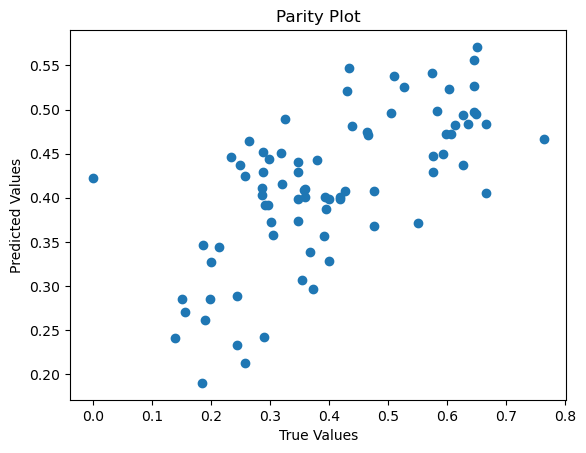

In [40]:
lasso = Lasso(alpha=0.01) 
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)

print("Validation MSE:", mean_squared_error(y_val, y_pred))
print("Validation R-sq:", lasso.score(X_val, y_val))

plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

To tune our hyperparamter, we will use scikit-learn's cross validation tool specifically for Lasso regression, LassoCV to find the optimal choice for alpha

In [41]:
lasso_cv = LassoCV(alphas=[0.1, 0.01, 0.05, 0.001, 0.005, 0.0005, 0.0001], cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

Optimal alpha: 0.005


Evaluation MSE: 0.009902842233027655
Evaluation R-sq: 0.6417283654733892


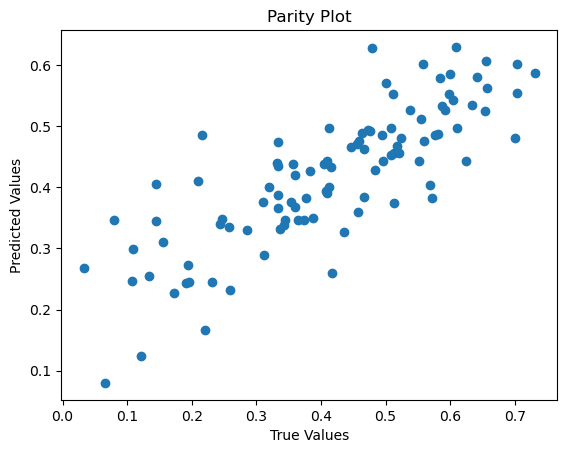

In [42]:
# input tuned alpha and evalate using test data
lasso = Lasso(alpha=0.005)
lasso.fit(X_train, y_train)

# get evaluation scores after tuning
y_pred = lasso.predict(X_test)

print("Evaluation MSE:", mean_squared_error(y_test, y_pred))
print("Evaluation R-sq:", lasso.score(X_test, y_test))

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Our model fit has improved to 64% and our MSE has decreased using our tuned hyperparameter. 

Now, using the absolute value of the coefficients, we can visualize the features that are most relevant to our target variable

<Figure size 1000x600 with 0 Axes>

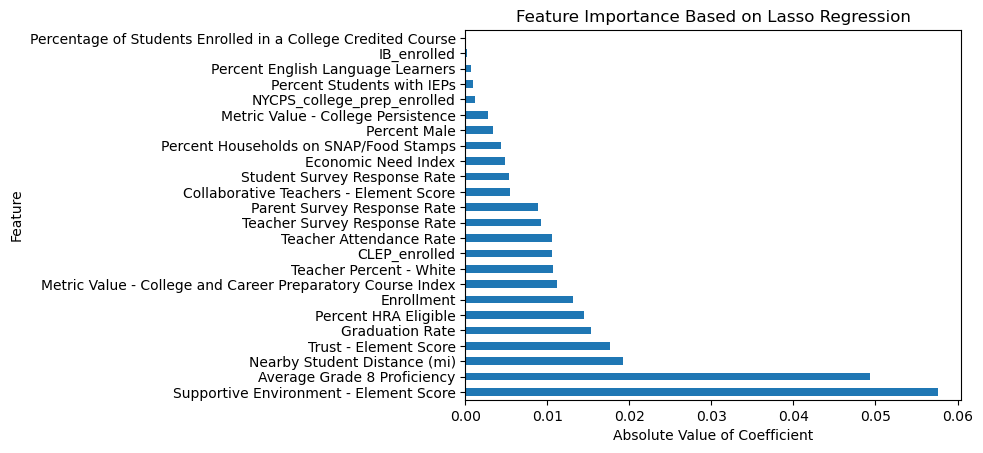

In [44]:
feature_names = X.columns
coefs = lasso.coef_

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})


coefs_df['abs_val_coef'] = coefs_df['Coefficient'].abs()
coefs_df = coefs_df.sort_values(by='abs_val_coef', ascending=False)

coefs_df = coefs_df.loc[coefs_df['abs_val_coef']>0]

plt.figure(figsize=(10, 6))
coefs_df.plot(kind='barh', x='Feature', y='abs_val_coef', legend=False)
plt.xlabel('Absolute Value of Coefficient')
plt.title('Feature Importance Based on Lasso Regression')
plt.show()


### Random Forest Regression

Random Forest is a supervised learning task that is an ensemble of many decision trees. Simply, decision trees work by starting at a root node and split depending on questions asked at each successive node. Random Forest is just many decision trees working together. It is superior to single decision trees because it prevents overfitting by averaging the outcome of the individual trees to get the final result. In addition, it is less sensitive to multicollinearity and normalization than other regression methods and can learn non-linear boundaries.

There are a few important hyperparamters to tune in random forest regression. This includes n_estimators (the number of trees in the forest), max_depth (the maximum depth or number of splits each tree can have), max_features (how many features are considered for splits), and bootstrap (whether bootstrapping (resampling with replacement) should be used) (https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

When bootstrapping is used, this is considered a bagging method (Bootstrap Aggregating).

We will apply the Random Forest Regressor and evaluate whether it improves our results.

In [115]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_regression, 'Percent of Students Chronically Absent')

In [116]:
model = train(X_train, y_train, 'regression', 'random_forest')
y_pred = validation_eval('regression',model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0836
Root Mean Squared Error (RMSE): 0.1092
R-squared: 0.5426


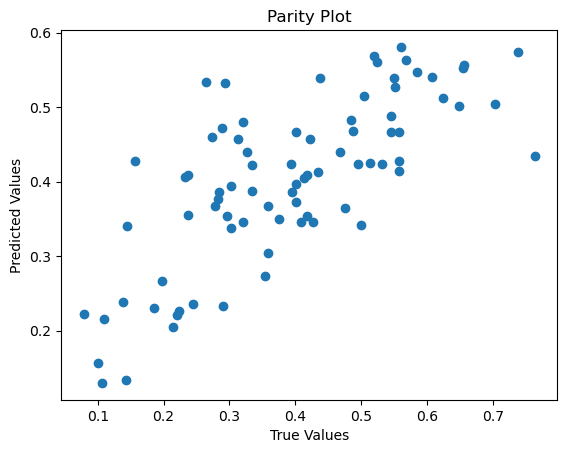

In [117]:
plt.scatter(y_val, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Tune and Retrain Model

In [118]:
tune(model, X_train, y_train, rf_param_grid, scoring='neg_mean_squared_error')

Best params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 50}


RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=50)

In [155]:
model = train(X_train, y_train, 'regression', 'random_forest', bootstrap = True, max_depth= 20, max_features= 'log2', n_estimators= 50)

In [156]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0858
Root Mean Squared Error (RMSE): 0.1082
R-squared: 0.5566


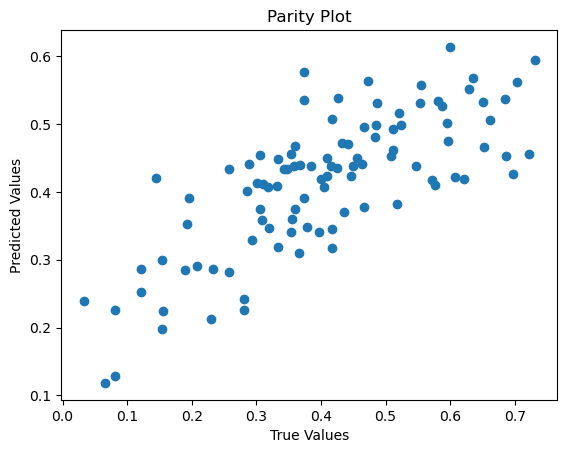

In [157]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

A handy output of Random Forest is feature importance. Now we can see which features are most important to our target variable.






In [158]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

<Figure size 1000x600 with 0 Axes>

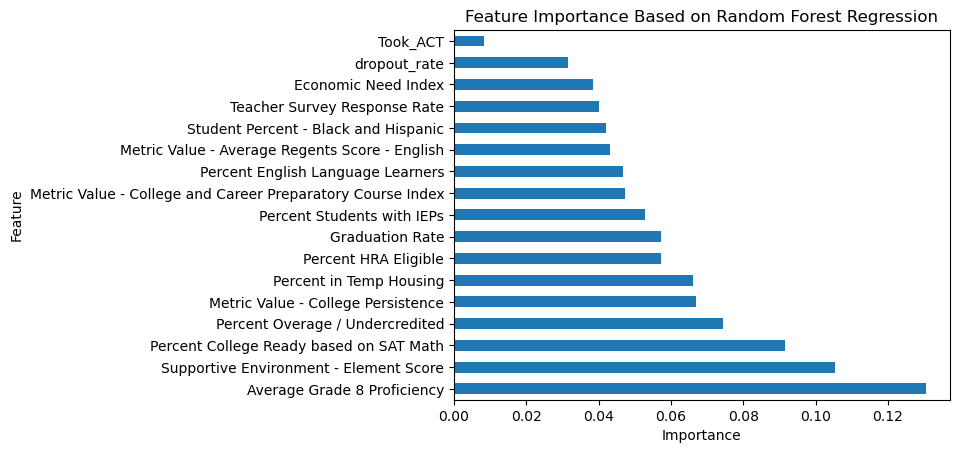

In [159]:
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Feature Importance Based on Random Forest Regression')
plt.show()

### Gradient Boosting Regression

We will try one more regression algorithm to see if we can improve our results.

Unlike the previous bagging method, we will now employ a boosting technique. In boosting, trees are grown sequentially rather than in parallel, as in bagging. This approach uses random sampling with replacement over weighted data, enabling each tree to learn from the errors of the previous models. By aggregating these weak learners into a strong learner, boosting optimizes the overall model performance.

The important hyperparameters to tune in gradient boosting are learning rate (controls for the contribution of each tree), n_estimators (number of trees), max_depth (controls number of nodes in the tree), and max_features (number of features to consider for splits) (https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [160]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_regression, 'Percent of Students Chronically Absent')

In [161]:
model = train(X_train, y_train, 'regression', 'gradient_boosting')
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0880
Root Mean Squared Error (RMSE): 0.1219
R-squared: 0.4108


In [162]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='neg_mean_squared_error')

Best params: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}


In [231]:
model = train(X_train, y_train, 'regression', 'gradient_boosting', learning_rate= 0.05, max_depth= 5, max_features= 'log2', n_estimators= 50)
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0907
Root Mean Squared Error (RMSE): 0.1187
R-squared: 0.4407


In [232]:
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0886
Root Mean Squared Error (RMSE): 0.1117
R-squared: 0.5151


Our tuned gradient boosting model performed better, but not as well as our LASSO and random forest models.

## Binary Classification

Binary classification is a supervised learning algorithm used for predicting categorical variables with two possible classes. The goal is to train a model that accurately predicts the correct class labels as much as possible. The output of a classification task is best evaluated using a confusion matrix, which provides insights into the model's performance. From the confusion matrix, we can calculate key metrics such as accuracy, precision, recall, and F1 score. The choice of the metric to maximize depends on the specific classification problem.

The calculations are as follows:
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
F1 is the harmonic balance of precision and recall, calculated as: 
$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Target variable:** *High Schools with high vs. low dropout risk*

In this case, accuracy is not an ideal metric because our classes are imbalanced. The worst-case scenario is failing to identify a school as having high dropout risk. If we treat the positive class as "high schools with high dropout risk," we aim to minimize false negatives (Type II errors) and maximize the recall score. To achieve this, we will use cross-validation to identify the algorithm that performs best for our objective.

First, we will create a binary variable for high dropout risk. High-risk schools will be defined as those in the 75th percentile or above of the dropout rate distribution. Additionally, we will exclude the "Graduation Rate" feature to avoid data leakage.

In [249]:
print(df_clean['dropout_rate'].describe())

count    501.000000
mean       5.358034
std        5.261403
min        0.000000
25%        1.225000
50%        3.700000
75%        7.700000
max       27.650000
Name: dropout_rate, dtype: float64


In [250]:
df_class = df_clean.copy()
df_class['high_dropout'] = [1 if x >= 7.7 else 0 for x in df_class['dropout_rate']]
df_class.drop(['dropout_rate','Graduation Rate'], axis=1, inplace=True)

### Random Forest Classification

We will begin by using a Random Forest classifier. This method is similar to the Random Forest regressor we explored earlier, but instead of predicting continuous variables, the trees now predict the class to which the data belongs. In Random Forest classification, the final prediction is determined by a majority vote among all the decision trees in the ensemble, rather than taking the average as in regression. 

In [251]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

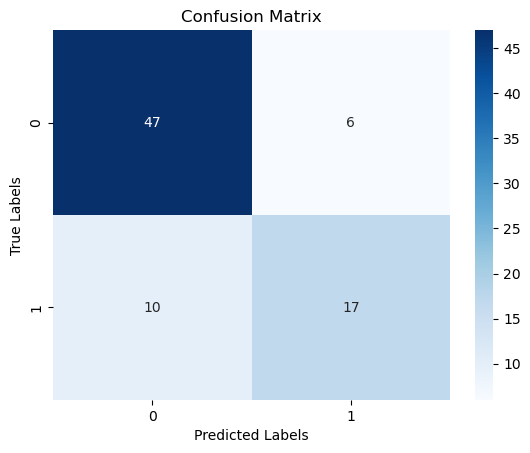

In [259]:
model = train(X_train, y_train, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [260]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.89      0.94      0.91        80
           1       0.71      0.57      0.63        21

    accuracy                           0.86       101
   macro avg       0.80      0.75      0.77       101
weighted avg       0.85      0.86      0.86       101



In [293]:
model = tune(model, X_train, y_train, rf_param_grid, scoring='f1')

Best params: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}


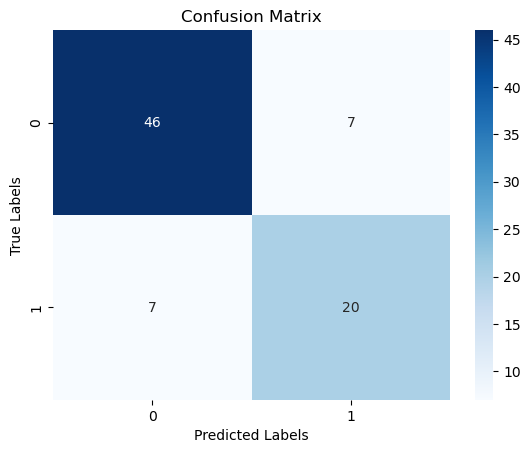

In [319]:
model = train(X_train, y_train, 'classification', 'random_forest', bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [320]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.88      0.90      0.89        80
           1       0.58      0.52      0.55        21

    accuracy                           0.82       101
   macro avg       0.73      0.71      0.72       101
weighted avg       0.82      0.82      0.82       101



<Figure size 1000x600 with 0 Axes>

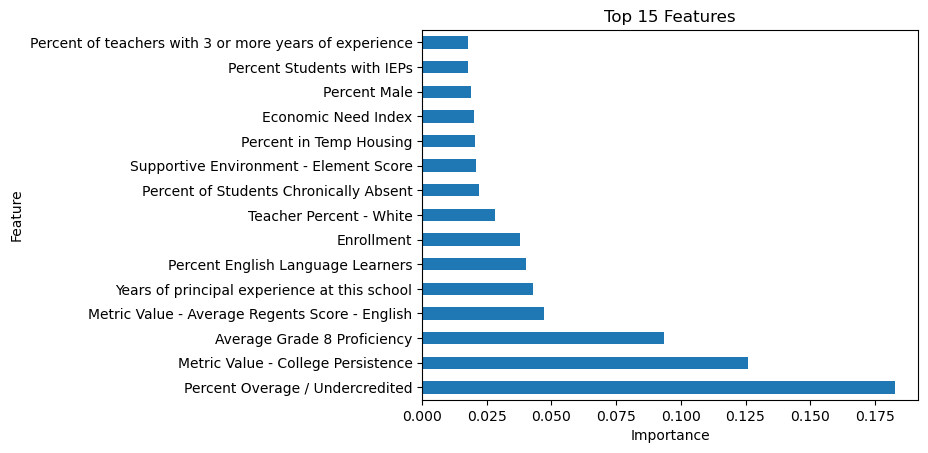

In [323]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Top 15 Features')
plt.show()

### Gradient Boosting Classification

Next, we will use a Gradient Boosting Classifier. This method is similar to the Gradient Boosting Regressor we tried earlier, but instead of predicting continuous values, the trees are trained to classify the data into predefined classes.

In [358]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

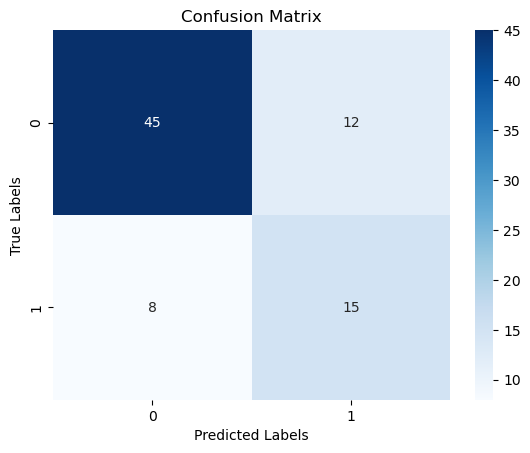

In [359]:
model = train(X_train, y_train, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [360]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.87      0.91      0.89        75
           1       0.70      0.62      0.65        26

    accuracy                           0.83       101
   macro avg       0.78      0.76      0.77       101
weighted avg       0.83      0.83      0.83       101



In [361]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='f1')

Best params: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}


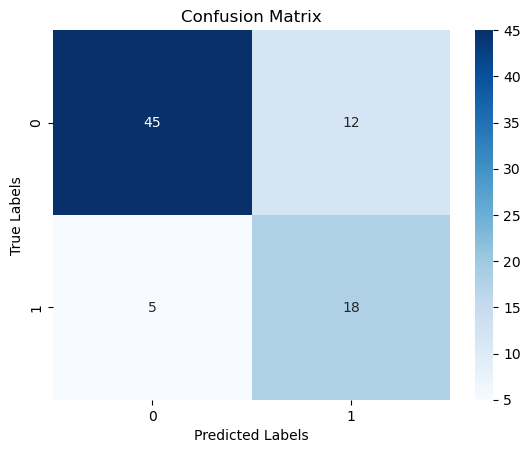

In [395]:
model = train(X_train, y_train, 'classification', 'gradient_boosting', learning_rate =0.2, max_depth=5, max_features='sqrt', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [396]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.88      0.93      0.90        75
           1       0.76      0.62      0.68        26

    accuracy                           0.85       101
   macro avg       0.82      0.77      0.79       101
weighted avg       0.85      0.85      0.85       101



The gradient boosting model is a bit more accurate among the binary classifiers, it is able to predict whether a high school is high or low dropout risk with 85% accuracy

## Multiclass Classification

Multiclass classification is similar to binary classification, but instead of predicting between two classes, we are now predicting across three or more classes. In this case, we are interested in classifying high schools based on their rates of college persistence, which will be categorized as low, medium, or high.

In our binary classification, we focused on identifying high schools with a high dropout risk rate. However, even if a high school is deemed "safe" with low dropout risk, we still want to intervene if the school has low college persistence rates. While preventing high school dropout is a significant achievement, we also want these efforts to translate into preventing dropouts from higher education.

**Target Variable:** *College Persistence*

First, we will divide the college persistence distribution into three bins, labeling them as Low, Medium, and High.

In [397]:
df_multi = df_clean.copy()
df_multi['college_persistence_ranking'] = pd.cut(df_multi['Metric Value - College Persistence'], bins=3, labels=['Low','Medium','High'])
df_multi.drop(['Metric Value - College Persistence'], axis=1, inplace=True)

### Random Forest Classifier
We will test how well a Random Forest Classifier predicts our labels, this time for three classes 

In [402]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

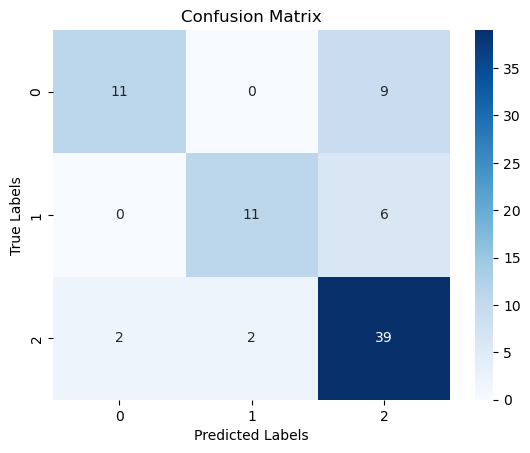

In [403]:
model = train(X_train, y_train, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [404]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.64      0.45      0.53        20
         Low       0.81      0.85      0.83        26
      Medium       0.75      0.82      0.78        55

    accuracy                           0.75       101
   macro avg       0.74      0.70      0.71       101
weighted avg       0.75      0.75      0.74       101



In [405]:
model = tune(model, X_train, y_train, rf_param_grid)

Best params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}


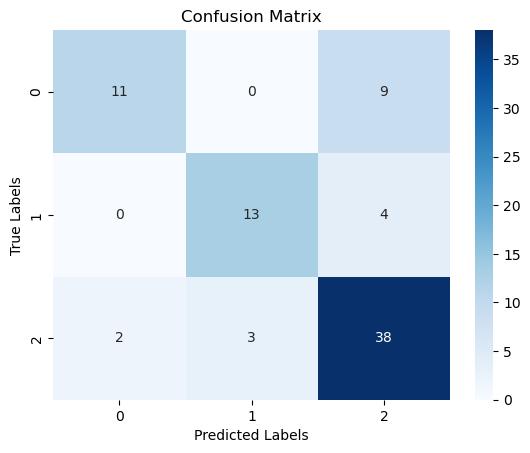

In [410]:
model = train(X_train, y_train, 'classification', 'random_forest', bootstrap=True, max_depth=20, max_features='sqrt', n_estimators=200)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [411]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.83      0.50      0.62        20
         Low       0.74      0.77      0.75        26
      Medium       0.74      0.84      0.79        55

    accuracy                           0.75       101
   macro avg       0.77      0.70      0.72       101
weighted avg       0.76      0.75      0.75       101



This model can correctly classify a high school with low college persistence with 74% accuracy

### Gradient Boosting

Now we will attempt a Gradient Boosting Classifier and see if it improves upon the Random Forest Classifier

In [412]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

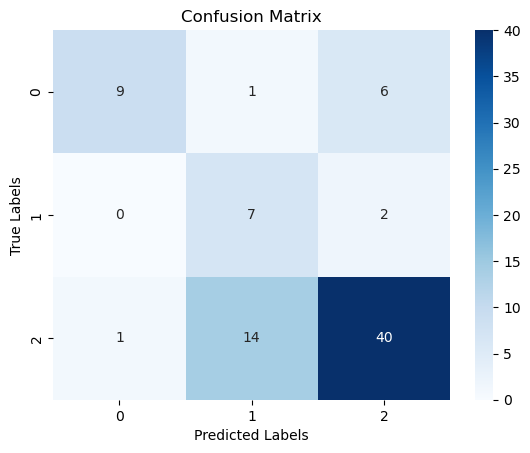

In [414]:
model = train(X_train, y_train, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [415]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.85      0.71      0.77        24
         Low       0.65      0.74      0.69        23
      Medium       0.76      0.78      0.77        54

    accuracy                           0.75       101
   macro avg       0.76      0.74      0.75       101
weighted avg       0.76      0.75      0.75       101



In [416]:
model = tune(model, X_train, y_train, boost_param_grid)

Best params: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 50}


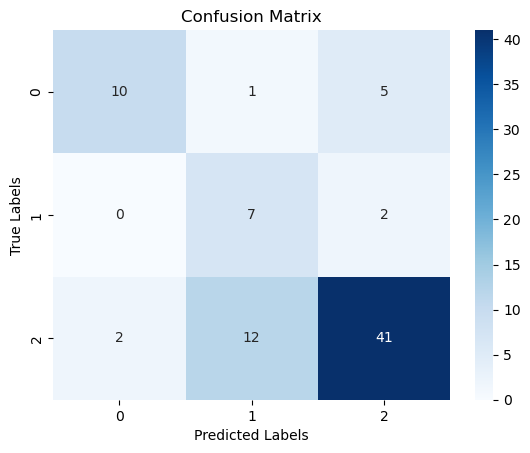

In [423]:
model = train(X_train, y_train, 'classification', 'gradient_boosting', learning_rate = 0.2, max_depth=3, max_features='log2', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [424]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.77      0.71      0.74        24
         Low       0.79      0.83      0.81        23
      Medium       0.80      0.81      0.81        54

    accuracy                           0.79       101
   macro avg       0.79      0.78      0.78       101
weighted avg       0.79      0.79      0.79       101



This model can correctly classify a high school with low college persistence with 79% accuracy, an improvement from our Random Forest Classifier